In [1]:
from collections import Counter
from re import split, sub
from requests import get

from bs4 import BeautifulSoup
from matplotlib.pyplot import clf, plot, show, text, title, xlabel, ylabel
from nltk import download
from nltk.corpus import stopwords
from pandas import DataFrame, Series
from seaborn import heatmap

download("stopwords")
stop_words = stopwords.words("english") + ["ut", "'re", ".", ",", "--", "'s", "?", "(", ")", ":", "'", '"', "-", "{", "}", "&", "|", u"\u2014"]

books = {}
book_contents = {}
book_word_frequencies = {}
book_word_distributions = {}
book_bucketed_word_distributions = {}

def get_book(URL, book_name):
    # Get book
    book = get(URL).text

    # Clean html
    book = BeautifulSoup(book, "html.parser").get_text()

    # Save to globals
    books[book_name] = book

def get_book_contents(book_name):
    if book_name not in books:
        raise "Get book by calling get_book first"

    contents = books[book_name].lower()
    contents = split("\s+", contents)
    for i, word in enumerate(contents):
        word = sub('[,"“”\.\'&\|:@>*;/=]', "", word)
        contents[i] = sub('^[0-9\.]*$', "", word)

    book_contents[book_name] = contents

    if book_name in book_word_frequencies:
        del book_word_frequencies[book_name]

def get_book_word_frequencies(book_name):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    word_frequencies = Counter(book_contents[book_name])
    for word in stop_words:
        word_frequencies.pop(word, None)
    book_word_frequencies[book_name] = word_frequencies

    if book_name in book_word_distributions:
        del book_word_distributions[book_name]

    if book_name in book_bucketed_word_distributions:
        del book_bucketed_word_distributions[book_name]

def get_all_book_info(URL, book_name):
    get_book(URL, book_name)
    get_book_contents(book_name)
    get_book_word_frequencies(book_name)

def get_total_actual_word_count(book_name):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    return len(book_contents[book_name])

def get_total_word_count(book_name):
    if book_name not in book_word_frequencies:
        raise "Get book word frequencies by calling get_book_word_frequencies first"

    return book_word_frequencies[book_name].total()

def get_n_most_common(book_name, n):
    if book_name not in book_word_frequencies:
        raise "Get book word frequencies by calling get_book_word_frequencies first"

    return book_word_frequencies[book_name].most_common(n)

def find_word_distribution(book_name, word):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    if book_name in book_word_distributions:
        if word in book_word_distributions[book_name]:
            return book_word_distributions[book_name][word]

    indicies = [i for i, book_word in enumerate(book_contents[book_name]) if book_word == word]
    if book_name not in book_word_distributions:
        book_word_distributions[book_name] = {}
    book_word_distributions[book_name][word] = indicies
    return indicies

def find_bucketed_word_distribution(book_name, word, bucket_size):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    if book_name in book_bucketed_word_distributions:
        if word in book_bucketed_word_distributions[book_name]:
            if bucket_size in book_bucketed_word_distributions[book_name][word]:
                return book_bucketed_word_distributions[book_name][word][bucket_size]

    indicies = find_word_distribution(book_name, word)
    buckets = [0 for i in range(((len(book_contents[book_name]) - 1) // bucket_size) + 1)]
    for index in indicies:
        buckets[index // bucket_size] += 1

    if book_name not in book_bucketed_word_distributions:
        book_bucketed_word_distributions[book_name] = {}
    if word not in book_bucketed_word_distributions[book_name]:
        book_bucketed_word_distributions[book_name][word] = {}
    book_bucketed_word_distributions[book_name][word][bucket_size] = buckets

    clf()
    plot(buckets, "o-")
    title(f"Frequency of {word} every {bucket_size} words in {book_name}")
    xlabel("Bucket")
    ylabel(f"Frequency of {word}")
    for i, count in enumerate(buckets):
        text(i, count, str(count), color="gray", fontsize=10)
    show()

    return buckets

def get_window_around_word(book_name, index, n):
    if book_name not in book_contents:
        raise "Get book contents by calling get_book_contents first"

    start = max(index - n, 0)
    end = min(index + n + 1, len(book_contents[book_name]) - 1)

    return book_contents[book_name][start:end]

def make_correlation_matrix(words, frequencies):
    data = []

    frequencies = [Series(i) for i in frequencies]
    for i, counts in enumerate(frequencies):
        if len(data) <= i:
            data.append([])
        for j in frequencies:
            data[i].append(counts.corr(j))

    df = DataFrame(data, columns=words, index=words)

    print(df)
    heatmap(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
book = "Alice's Adventures in Wonderland by Lewis Carroll"
get_all_book_info("https://www.gutenberg.org/ebooks/11.txt.utf-8", book)

In [3]:
print(get_total_actual_word_count(book))
print(get_total_word_count(book))

29565
14955


In [4]:
print(get_n_most_common(book, 15))

[('said', 456), ('alice', 374), ('little', 125), ('one', 97), ('project', 88), ('', 88), ('went', 83), ('like', 82), ('would', 78), ('know', 78), ('could', 75), ('thought', 73), ('see', 67), ('queen', 65), ('time', 62)]


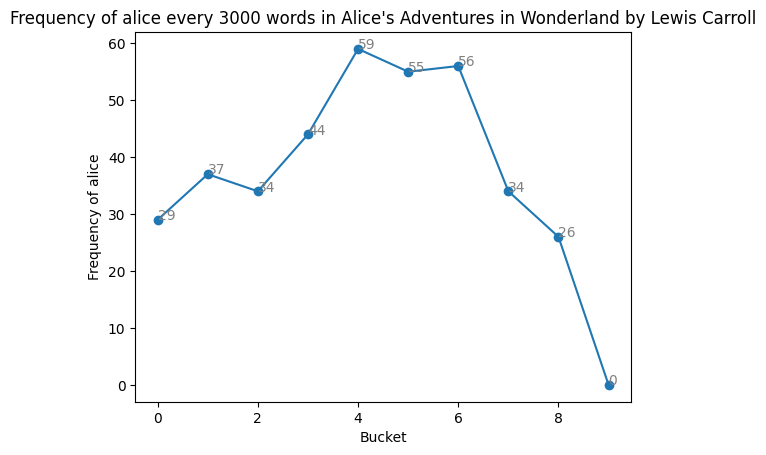

[29, 37, 34, 44, 59, 55, 56, 34, 26, 0]


In [5]:
print(find_bucketed_word_distribution(book, "alice", 3000))

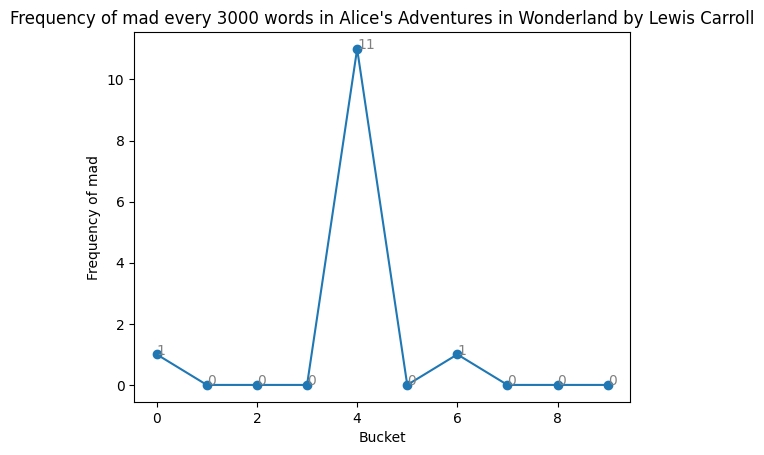

[1, 0, 0, 0, 11, 0, 1, 0, 0, 0]


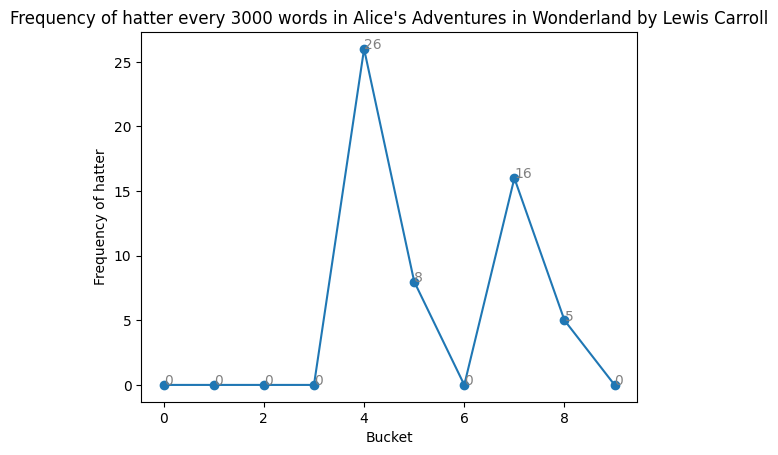

[0, 0, 0, 0, 26, 8, 0, 16, 5, 0]


In [6]:
print(find_bucketed_word_distribution(book, "mad", 3000))
print(find_bucketed_word_distribution(book, "hatter", 3000))

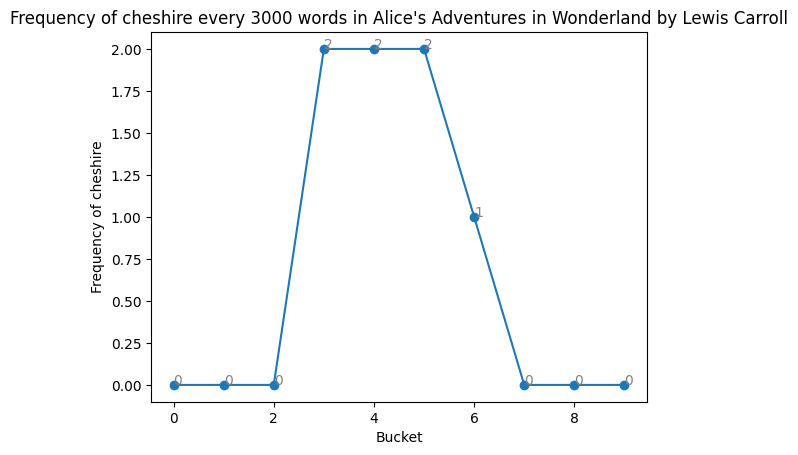

[0, 0, 0, 2, 2, 2, 1, 0, 0, 0]


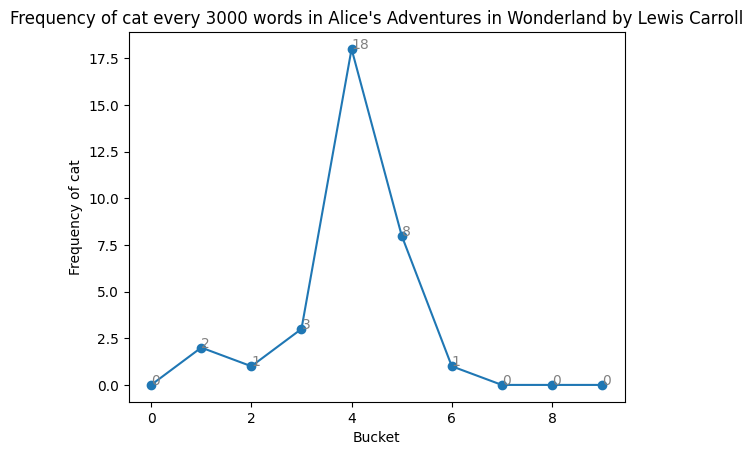

[0, 2, 1, 3, 18, 8, 1, 0, 0, 0]


In [7]:
print(find_bucketed_word_distribution(book, "cheshire", 3000))
print(find_bucketed_word_distribution(book, "cat", 3000))

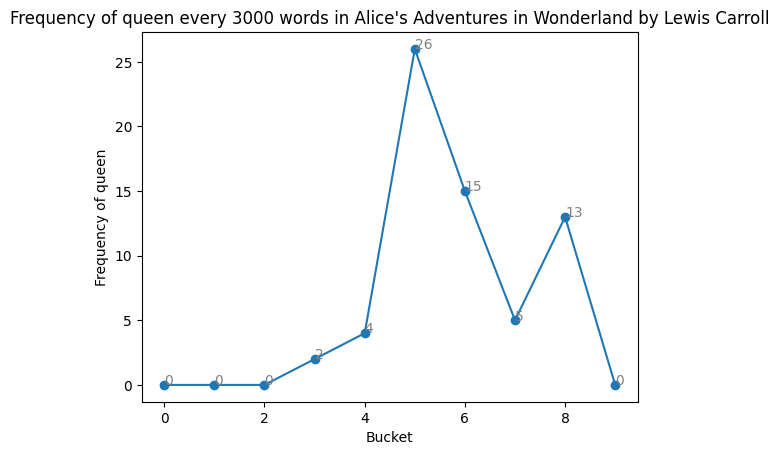

[0, 0, 0, 2, 4, 26, 15, 5, 13, 0]


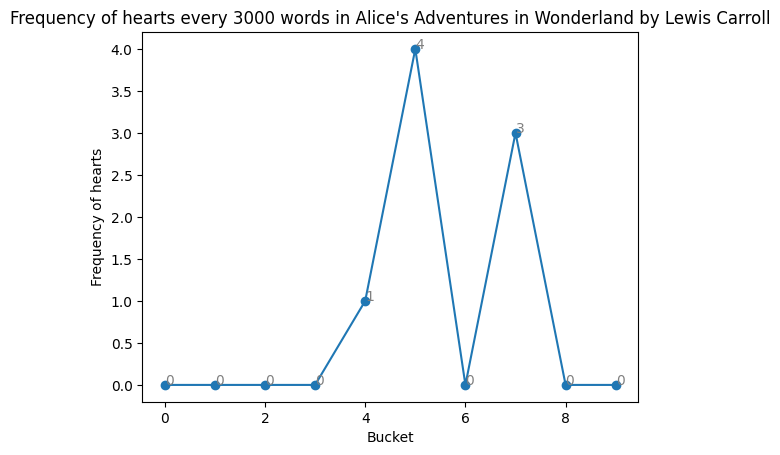

[0, 0, 0, 0, 1, 4, 0, 3, 0, 0]


In [8]:
print(find_bucketed_word_distribution(book, "queen", 3000))
print(find_bucketed_word_distribution(book, "hearts", 3000))

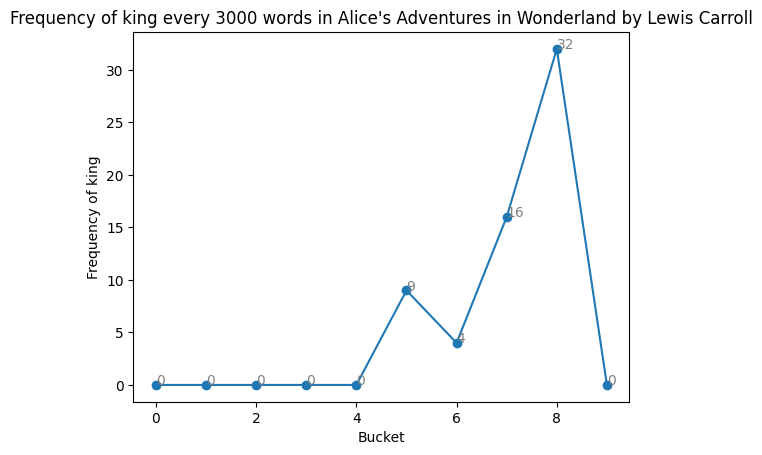

[0, 0, 0, 0, 0, 9, 4, 16, 32, 0]


In [9]:
print(find_bucketed_word_distribution(book, "king", 3000))

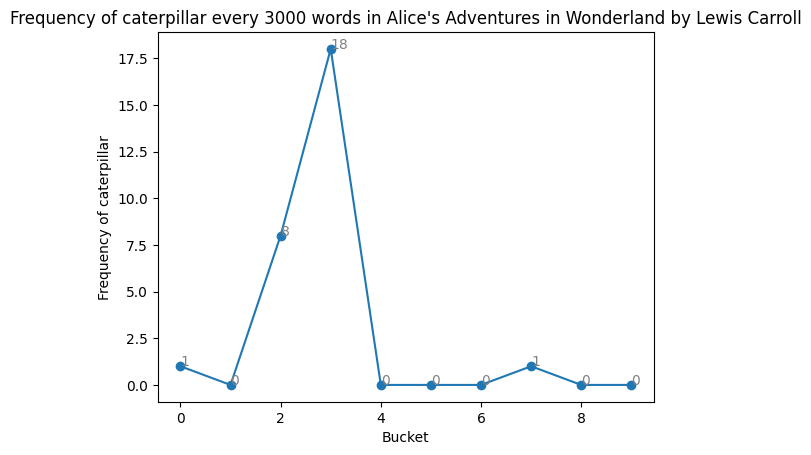

[1, 0, 8, 18, 0, 0, 0, 1, 0, 0]


In [10]:
print(find_bucketed_word_distribution(book, "caterpillar", 3000))

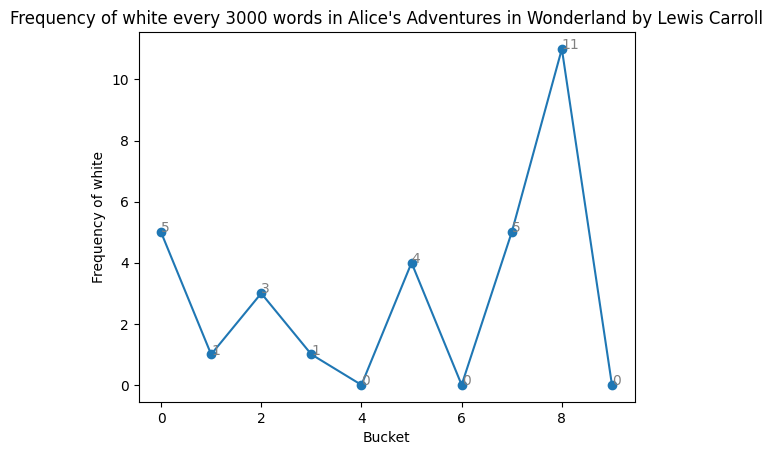

[5, 1, 3, 1, 0, 4, 0, 5, 11, 0]


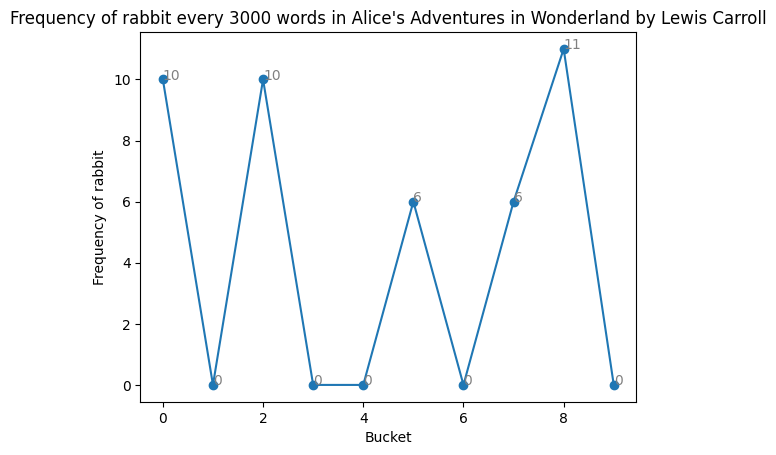

[10, 0, 10, 0, 0, 6, 0, 6, 11, 0]


In [11]:
print(find_bucketed_word_distribution(book, "white", 3000))
print(find_bucketed_word_distribution(book, "rabbit", 3000))

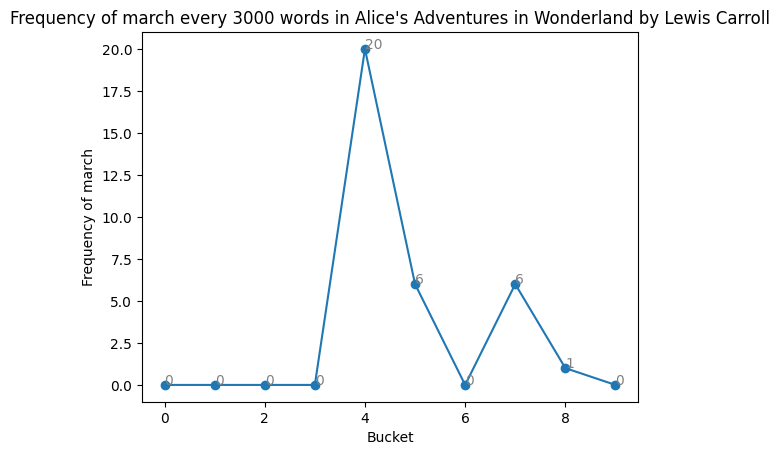

[0, 0, 0, 0, 20, 6, 0, 6, 1, 0]


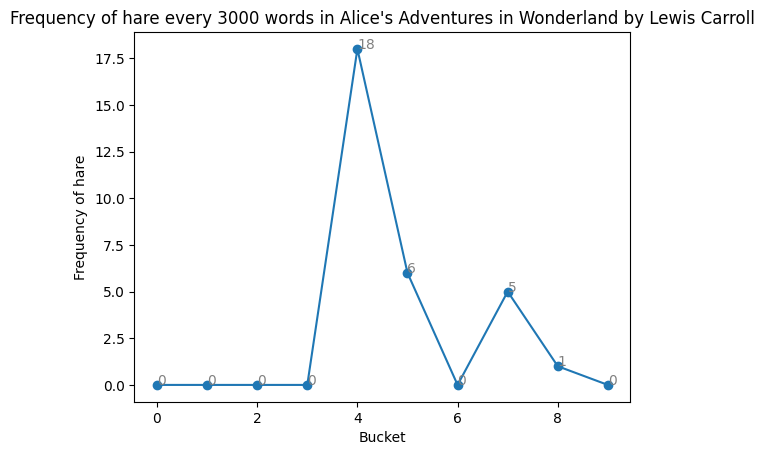

[0, 0, 0, 0, 18, 6, 0, 5, 1, 0]


In [12]:
print(find_bucketed_word_distribution(book, "march", 3000))
print(find_bucketed_word_distribution(book, "hare", 3000))

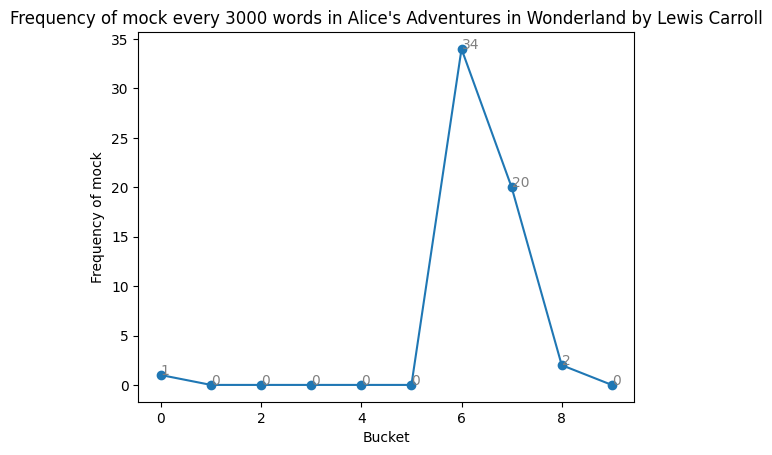

[1, 0, 0, 0, 0, 0, 34, 20, 2, 0]


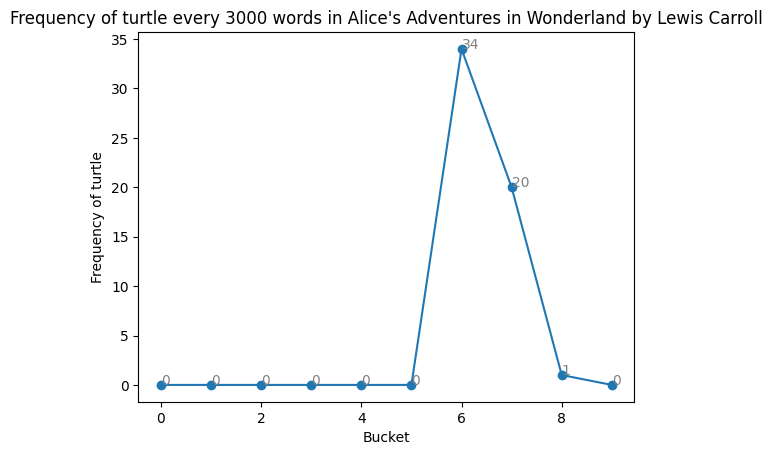

[0, 0, 0, 0, 0, 0, 34, 20, 1, 0]


In [13]:
print(find_bucketed_word_distribution(book, "mock", 3000))
print(find_bucketed_word_distribution(book, "turtle", 3000))

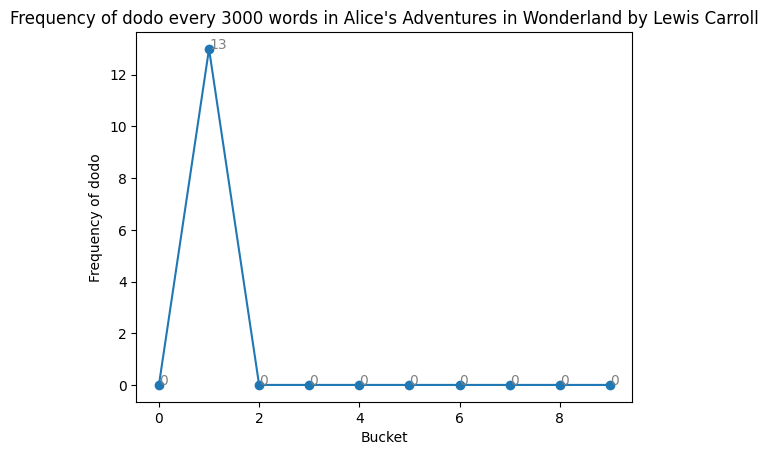

[0, 13, 0, 0, 0, 0, 0, 0, 0, 0]


In [14]:
print(find_bucketed_word_distribution(book, "dodo", 3000))

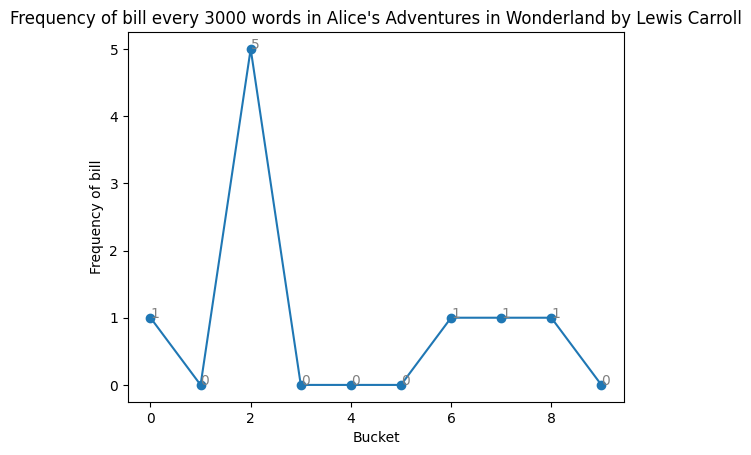

[1, 0, 5, 0, 0, 0, 1, 1, 1, 0]


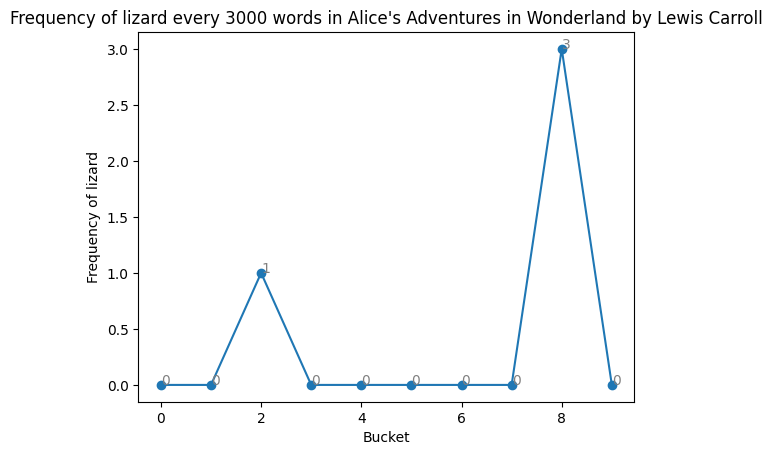

[0, 0, 1, 0, 0, 0, 0, 0, 3, 0]


In [15]:
print(find_bucketed_word_distribution(book, "bill", 3000))
print(find_bucketed_word_distribution(book, "lizard", 3000))

                alice       mad    hatter  cheshire       cat     queen  \
alice        1.000000  0.455581  0.417539  0.733266  0.622587  0.482875   
mad          0.455581  1.000000  0.776884  0.474149  0.883685 -0.094075   
hatter       0.417539  0.776884  1.000000  0.386693  0.762478  0.141059   
cheshire     0.733266  0.474149  0.386693  1.000000  0.735537  0.447293   
cat          0.622587  0.883685  0.762478  0.735537  1.000000  0.191672   
queen        0.482875 -0.094075  0.141059  0.447293  0.191672  1.000000   
hearts       0.349903  0.013157  0.522457  0.349206  0.310840  0.609425   
king        -0.111354 -0.230609  0.179471 -0.229439 -0.230485  0.471708   
caterpillar  0.085610 -0.194691 -0.291653  0.326439 -0.100422 -0.303536   
white       -0.215027 -0.317621  0.007180 -0.371910 -0.331049  0.288872   
rabbit      -0.207679 -0.308901 -0.096980 -0.440859 -0.339140  0.130394   
march        0.501985  0.901053  0.953127  0.532163  0.914026  0.128452   
hare         0.512935  0.

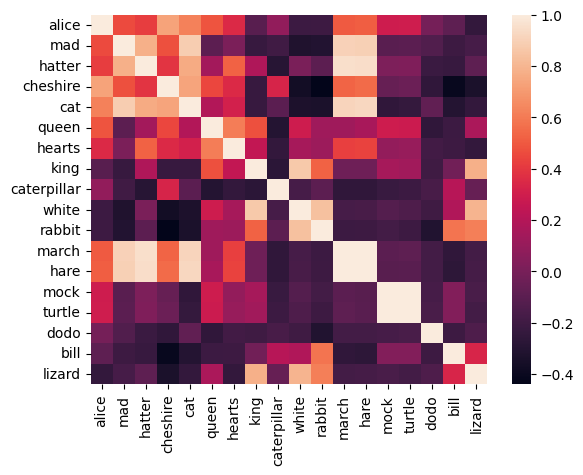

In [16]:
make_correlation_matrix(list(book_bucketed_word_distributions[book].keys()), [book_bucketed_word_distributions[book][i][3000] for i in book_bucketed_word_distributions[book].keys()])

# Findings

## Text Selection and Reasoning

During the exploratory phase where we were exploring various books and approaches for this project, one of the ideas was to see how the frequnecy with which a character's name is used changes throughout the course of the book. With this ideas a mind, we picked a couple of books and just looked at the change in frequency of the main character. This book *Alice's Adventures in Wonderland by Lewis Carroll* had an interesting trend with the usage of **alice**, the main character, increased in the first half of the book and decreased in the second half.

## Analysis Overview

The aim of this analysis is to see how the frequency with which a character's name appears changes as the book progresses and to see if those trends can reveal something about the characters, plot, and book.

The hypothesis was we can construct a rough idea how many arcs there are in the book by inflow and outflow of characters and get a rough idea of what characters are related by when (and how much) they occur.

Some characters are identified by more than one word, for example, Mad Hatter. In such cases, we included trends for each word side-by-side to get a better idea of the occurence of such characters.

The character list is by no means exhaustive.

## Intermediate Results

* Alice appears most frequenctly in the book with a spike occurrence in the middle.
* Mad Hatter seems to appear towards the middle and end of the book.
* Cheshire cat's appears in the middle of the book but the frequency is a little hard to pinpoint with the stark difference in frequency between the words *cheshire* and *cat*.
* The Queen of Hearts appears primarily in the second half of the book.
* The King appears predominantly in the tail end of the book.
* Caterpillar mostly appears in the beginning of the book.
* White Rabbit seems to be a constant character although their appearance is rather sporadic.
* The March Hare shows up primarily in the middle and end of the book.
* The Mock Turtle shows up in the latter half of the book.
* The Dodo only appears in the beginning of the book.
* Bill the Lizard seems to be an infrequent character with a couple appearances at the beginning and end.

---

* Alice, Mad Hatter, Cheshire Cat, March Hare, and the Mock Turtle all seem to cooccur.
* The King and Queen of Hearts and the White Rabbit seem to cooccur.
* Caterpillar and Cheshire Cat seem to have some relation.
* The rest of the character seem random or have a somewhat negative correlation with other characters in terms of how often their identifying words appear in the book.

## Final Analysis, Summary, and Reflection

The seems to be roughly 3 sections of the book.

* Section 1: Buckets 0-2 with characters like Alice, the White Rabbit, the Dodo, and Bill the Lizard appearing most.
* Section 2: Buckets 3-6 with lots of characters joining the fray. Alice, Mad Hatter, Cheshire Cat, the Queen and King of Hearts, Catepillar (who is more concentration towards the beginning of the section), the March Hare, and the Mock Turtle appear a lot.
* Sectio 3: Buckets 7-9 where Alice becomes less of a focus with her occurrence counts decreasing, but certain characters rising like Mad Hatter, the King and Queen of Hearts, the White Rabbit, and a little bit of Bill the Lizard.

Based on the large values of Alice's frequency, we can assume that she is likely an important (if the main) character of the story. The royalty seem to serve an important role in the plot towards the middle and latter half of the book. The middle of the book is where a lot of the content seems to be concentration with lots of character appearances.

Based on the cooccurence matrix, the seem to be three clusters of characters, cluster 1 is Alice, Mad Hatter, Cheshire Cat, March Hare, and the Mock Turtle, cluster 2 is the King and Queen of Hearts and the White Rabbit, clutser 3 is a bucket of all the remaining characters.

In summary, from observing the frequency with which character's identifying words appear, we can roughly figure out how many sections there are to the book (plot-wise), when one section transitions to another, and cluster groups of characters based on their appearance.

This analysis could be take a few steps further by including a more exhaustive list of characters, playing with the window size, change from word windows to chapter windows, analyzing the words surrounding each occurance of a character, and qualitatively analyzing hot stops where lots of characters coocur.